In [1]:
import utils
import os 
import sys

In [3]:
import os 
import sys
import torch
import torch
import torch
from selfsupervisedlearning import augdataset
from selfsupervisedlearning import loss, train_utils, models
from selfsupervisedlearning import utils
import pandas as pd



In [11]:
import torch
import torch
import torch
from selfsupervisedlearning import augdataset
from selfsupervisedlearning import loss, train_utils, models
from selfsupervisedlearning import utils
import pandas as pd


In [12]:
# function to the features from images 
# model = models.EfficientNetModel(features_dim=128, v='b1', mlp_dim=2048)
# model = models.EfficientNetModelMLP(features_dim=1024, v='b2', mlp_dim=1024)
model = models.ResnetMLP(features_dim=1024, v='18', mlp_dim=1024)
model.cuda()
# model.load_state_dict(torch.load('../models/modelv9_efficientnetb1_alldata.pt')['model'])
model.load_state_dict(torch.load('../models/modelv21_resnet18_alldata.pt')['model'])
# model = torch.load('../tmp_models/modelv12_efficientnetb2_alldata_e200.pt')[0]

In [20]:
import models as m
# model = m.EfficientNetModelMLP(features_dim=1024, v='b2', mlp_dim=1024)
model = m.ResnetMLP(features_dim=1024, v='18', mlp_dim=1024)

model = torch.nn.Sequential(model, 
                   torch.nn.Linear(1024, 15))

model.load_state_dict(torch.load('/home/devi_prasad/UrineSedimentation/clustering/self-supervised-clustering/fine-tune/data/models/model_v06_phase3_state_dict_best_acc.pt')['model_weight'])
model = model.cuda()

In [21]:
train_fps, train_features = utils.get_features(model, train_df[:].fp.values, batch_size=128)
test_fps, test_features = utils.get_features(model, test_df[:].fp.values, batch_size=128)

Number of Images:  184355
Compose(
    Resize(size=(90, 90), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)
Number of Images:  23045
Compose(
    Resize(size=(90, 90), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', )
neigh.fit(np.vstack(train_features), train_df.label)

y_pred = neigh.predict(np.vstack(test_features))
y_true = test_df.label.values


In [23]:
a

NameError: name 'a' is not defined

In [ ]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)
import pandas as pd
from selfsupervisedlearning.confusion_matrix_pretty_print import plot_confusion_matrix_from_data, pretty_plot_confusion_matrix

fig = pretty_plot_confusion_matrix(pd.DataFrame(pd.DataFrame(cm.matrix).values.T,  columns=cm.classes,
                                          index=cm.classes), figsize=(15, 15),)

#### get pred vectors of misclassified images

In [15]:
def convert_to_df(fps, features):
#     additional_mappings = {'DRBC': 'RBC', 'MAR': 'RBC', 'RBCC': 'RBC', 'SQECC': 'SQEC'}
    additional_mappings = {}
    df_preds = pd.DataFrame(zip(fps, features), columns=['fp', 'feature_vector'])
    df_preds['true_label'] = df_preds.fp.apply(lambda x: os.path.basename(os.path.dirname(x)))
    df_preds['filename'] = df_preds.fp.apply(lambda x: os.path.basename(x))
    df_preds['base_folder'] = df_preds.fp.apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))
    
    df_preds.true_label = df_preds.true_label.replace(additional_mappings)
    return df_preds
df_preds = convert_to_df(fps, features)
df_preds['true_label'] = df_misclassified[:].true_label.values
df_preds['pred_class'] = df_misclassified[:].pred_class.values 
# df_preds

#### Load the unlabelled dataset

In [16]:
unlabelled_df = pd.read_csv('../train-test-split/data/unannotated_fp_v3.csv')
unlabelled_df = unlabelled_df[unlabelled_df.fp.str.contains('hiraka')]
# unlabelled_df = unlabelled_df.sample(200000)
unlabelled_df.shape

(1074723, 3)

In [17]:
# model
#  /mnt/UrineSediment/SEG_img/annotation_ahq

In [18]:
%%time


fps, features = utils.get_features(model, [
#                                             '/home/devi_prasad/UrineSedimentation/data_imgs/10k_annotatio_details_20200901/confusing/*.*', 
#     '/home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_cu_mitsubishi_single_slice_dataset_20200226/train/**/*.*',
#     '/mnt/Users/sucheta_chauhan/14classDataReannotatedfpv9.1/test/**/*.*',
    
                                    ] + unlabelled_df.fp.values.tolist(), batch_size=256, num_workers=32)
df_unlabelled = convert_to_df(fps, features)

Number of Images:  1074723
Compose(
    Resize(size=(90, 90), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)
CPU times: user 1min 34s, sys: 43.8 s, total: 2min 18s
Wall time: 10min 47s


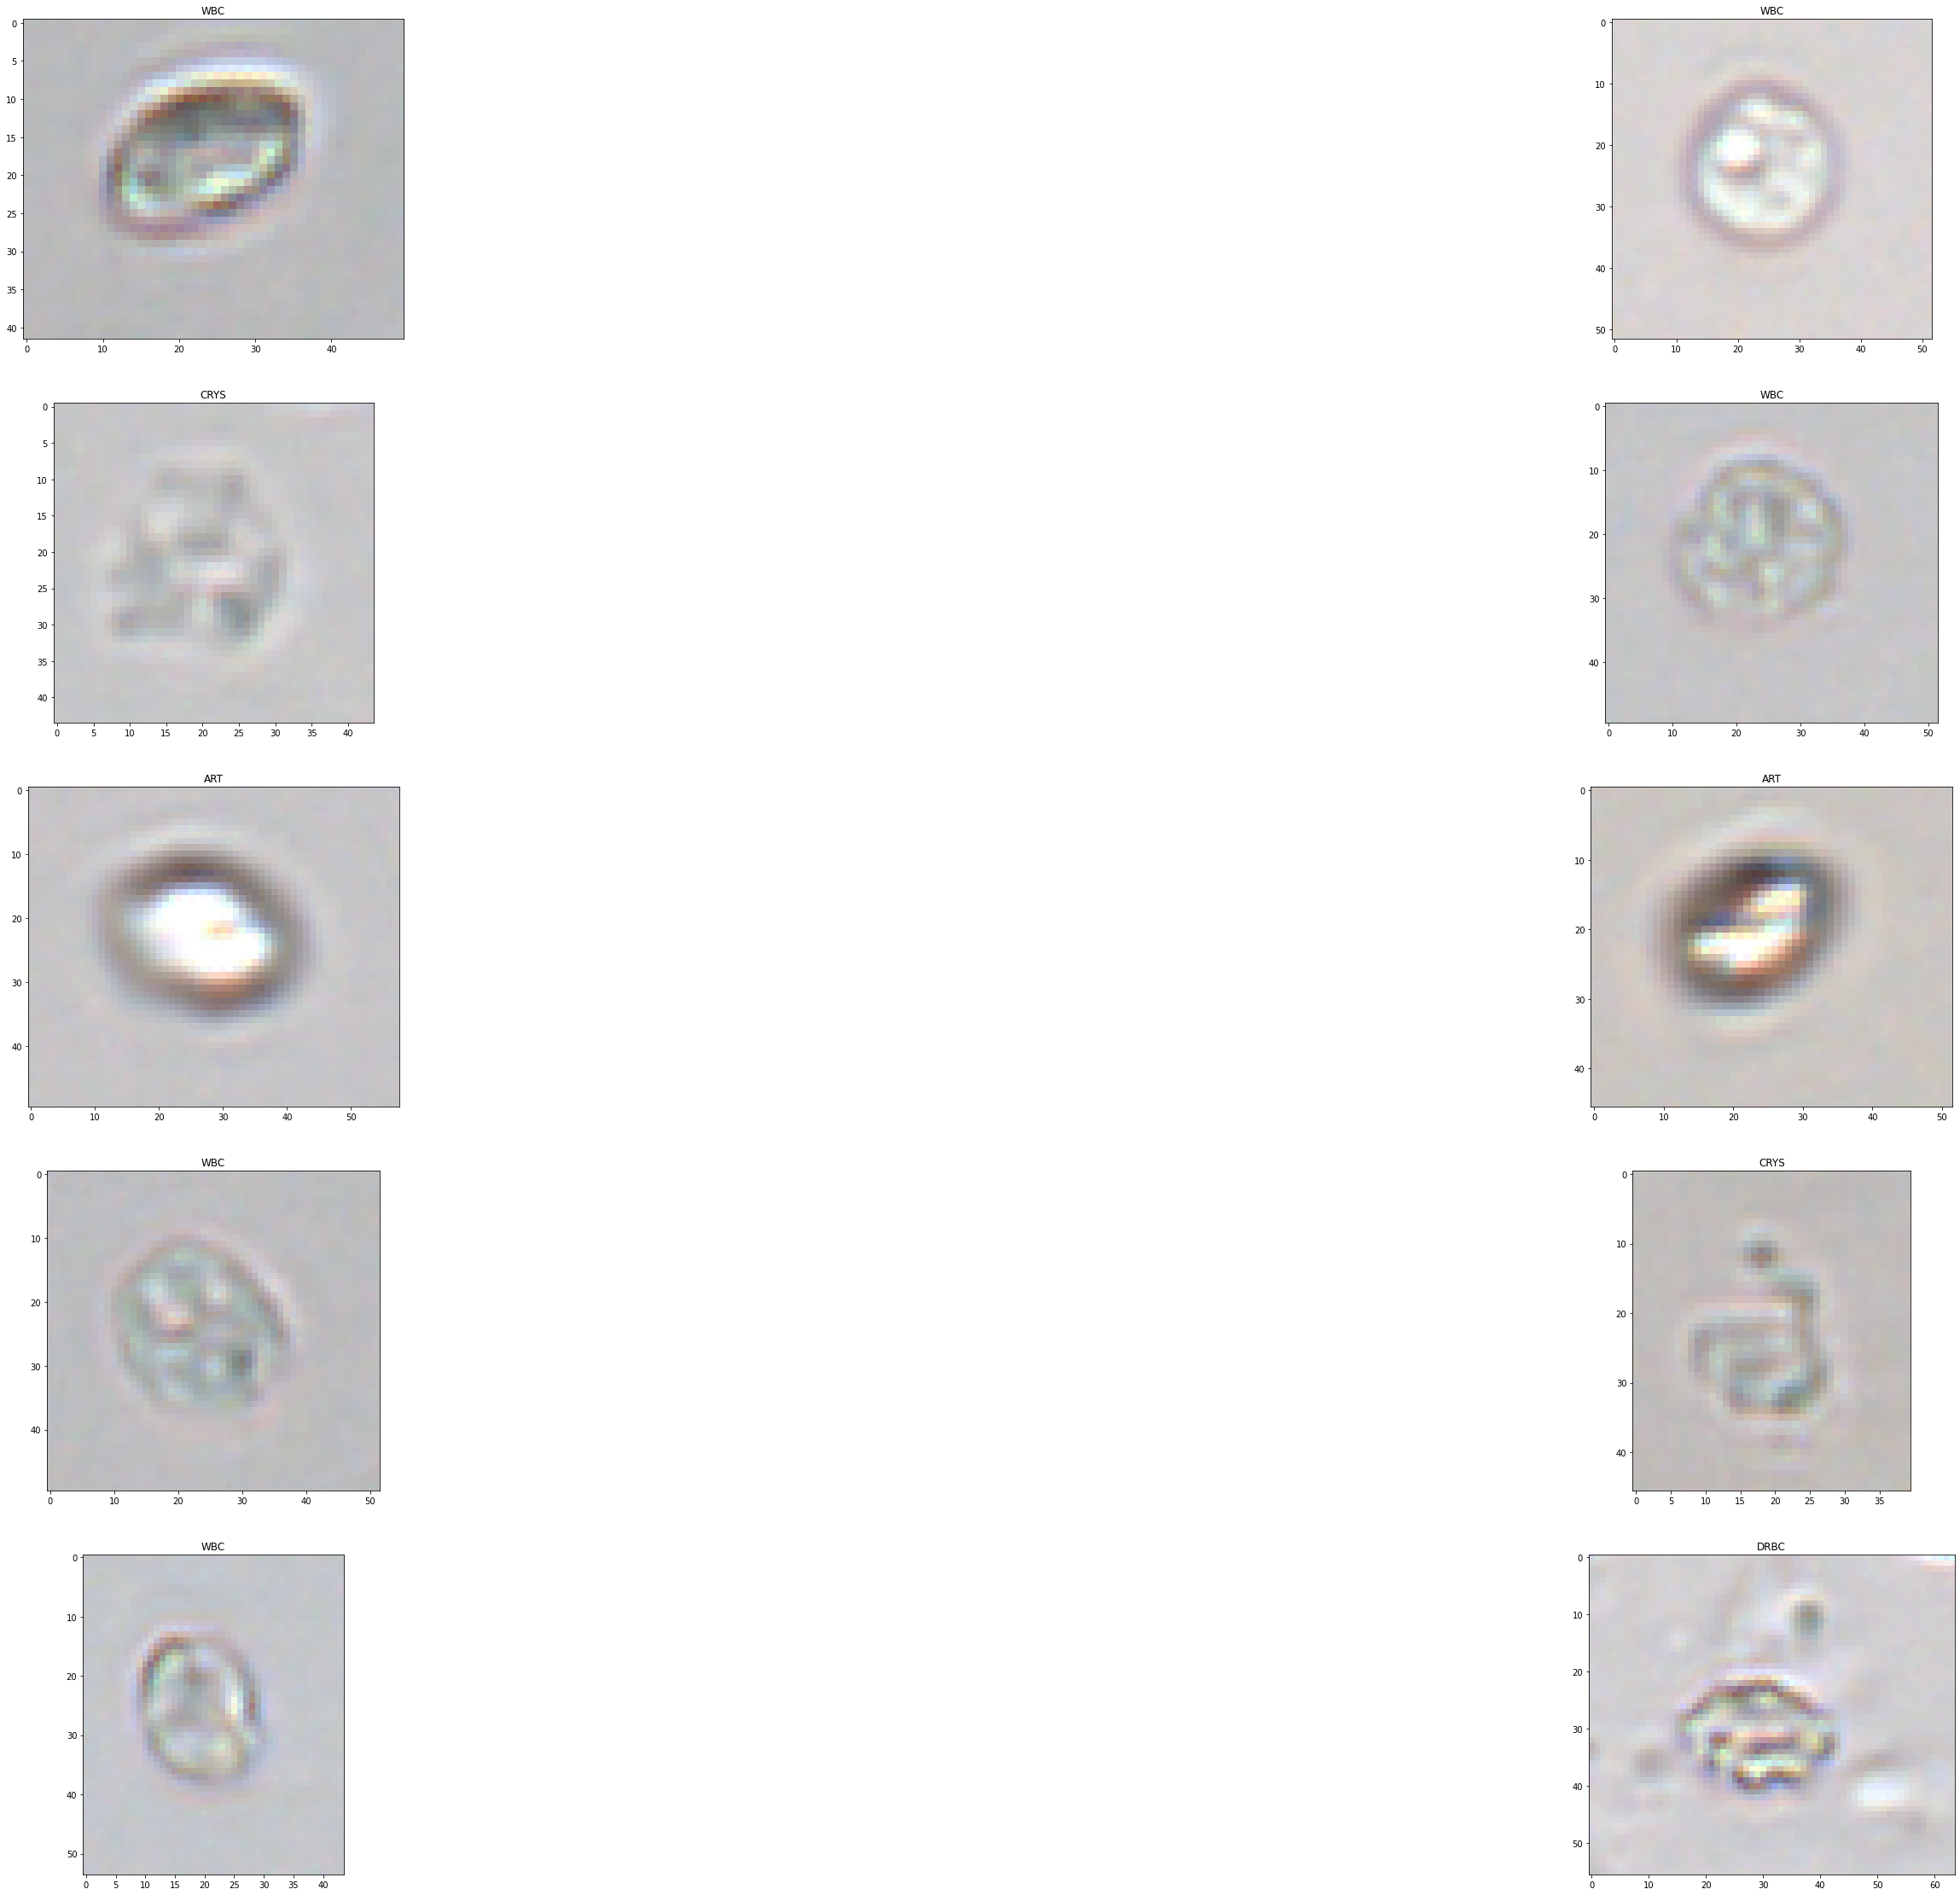

In [19]:
from skimage import io
images = [io.imread(fp) for fp in df_preds[df_preds.true_label.isin(['RBC'])].fp.values[:10]]
show_images(images, titles=df_preds[df_preds.true_label.isin(['RBC'])].pred_class.values[:10])

In [20]:
%%time
from sklearn.neighbors import NearestNeighbors

import numpy as np
n_neighbors = 100
radius = .85
# df_mc_to_find = df_preds[df_preds.true_label.isin(['WBC', 'RBC', 'WBCC'])].reset_index(drop=True)
df_mc_to_find = df_preds[df_preds.true_label.isin(['WBC', 'RBC', 'WBCC', 'NHC'])].reset_index(drop=True)
# df_mc_to_find = df_preds[:].reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=12).fit(np.vstack(df_unlabelled.feature_vector.values), )
distances, indices = nbrs.kneighbors(np.vstack(df_mc_to_find.feature_vector.values), n_neighbors, )
# distances, indices = nbrs.radius_neighbors(np.vstack(df_mc_to_find.feature_vector.values), radius=radius, sort_results=True)
# indices

CPU times: user 33min 5s, sys: 5.32 s, total: 33min 10s
Wall time: 15min 49s


In [21]:
len([x for i in indices for x in i]), len(distances)

(27300, 273)

In [22]:
# df_unlabelled.iloc[indices[0]].fp.values

In [23]:
import shutil, os
# class_wise_thresholds = {'WBC': 0.85, 'RBC': 0.85, 'WBCC': 0.7, 'YST': 0.7, }
class_wise_thresholds = {}
min_threshold = 0.85

output_dir = '../../../data_imgs/train_refinement_modelv06_0.85threshold_WBCRBCYSTWBCC'
# output_dir = '../../../data_imgs/DRBC_similar_images'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)

classes = df_mc_to_find.true_label.unique()
# os.mkdir(os.path.join(output_dir, 'misclassified_similar_data'))
# os.mkdir(os.path.join(output_dir, 'new_similar_data'))

additional_similar_images_to_train = []
for class_ in classes:
    class_dir = os.path.join(output_dir, class_)
    os.mkdir(class_dir)
#     class_dir = os.path.join(output_dir, 'new_similar_data', class_)
#     os.mkdir(class_dir)

for i, idx in enumerate(df_mc_to_find.index):
    mc_image_fp = df_mc_to_find.iloc[idx].fp
    mc_image_class = df_mc_to_find.iloc[idx].true_label
    pred_image_class = df_mc_to_find.iloc[idx].pred_class
    mc_image_dest = os.path.join(output_dir, mc_image_class, f'{i}${pred_image_class}${mc_image_class}#{os.path.basename(mc_image_fp)}')
    similar_image_fps =  df_unlabelled.iloc[indices[idx]].fp.values
    similar_image_dists = distances[idx]
    
    shutil.copy(mc_image_fp, mc_image_dest)
    max_dist = class_wise_thresholds.get(mc_image_class, min_threshold)
    for fp, dist in zip(similar_image_fps, similar_image_dists):
        if dist >= max_dist:
            continue
        os.makedirs(os.path.join(output_dir, mc_image_class, str(i), mc_image_class,), exist_ok=True)
        similar_image_dest = os.path.join(output_dir, mc_image_class, str(i), mc_image_class, f'{dist}#{os.path.basename(fp)}')
        shutil.copy(fp, similar_image_dest)
        additional_similar_images_to_train.append([fp, mc_image_class])

In [32]:
df_add_train = pd.DataFrame(additional_similar_images_to_train, columns=['fp', 'label'])

In [33]:
df_add_train.to_csv('data/additional_train_modelv06.csv')

In [29]:
df_mc_to_find.true_label.value_counts()

RBC     118
WBC      98
NHC      46
WBCC     11
Name: true_label, dtype: int64

In [30]:
118 * 20

2360

In [28]:
df_add_train.drop_duplicates().true_label.value_counts()

WBC     6365
RBC     6161
NHC     2384
WBCC     953
Name: true_label, dtype: int64

In [26]:
df_add_train.true_label.value_counts()

WBC     6593
RBC     6546
NHC     2946
WBCC     956
Name: true_label, dtype: int64

In [55]:
!7z a {os.path.abspath(os.path.dirname(output_dir))}/{os.path.basename(output_dir)}.7z {output_dir}


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,40 CPUs Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz (406F1),ASM,AES-NI)

Scanning the drive:
  0M Scan  ../../../data_img                            454 folders, 4558 files, 53168234 bytes (51 MiB)

Creating archive: /home/devi_prasad/UrineSedimentation/data_imgs/train_refinement_modelv06_0.85threshold_WBCRBCYSTWBCC.7z

Items to compress: 5012

      1% 427 + train_refinement_modelv06_0.85t . 523164745_6_0028_00170076_0.p                                                                            2% 604 + train_refinement_modelv06_0.85 . 28103236_23_0103_00000093_0.pn                                                                            4% 787 + train_refinement_modelv06_0.85t . (3745)-0099-802-686-48-48-0.p                                                                            5% 1017 + train_refinement_modelv06_0.85 . 01113712_2_0002_00000222_0.

##### removing the annotations from previous data

In [72]:
import pickle
import glob
import pandas as pd
import os

output_dir = os.path.abspath('../../../data_imgs/train_refinement_p2_allclasses/')
def convert_to_df_2(fps,):
    additional_mappings = {'DRBC': 'RBC', 'MAR': 'RBC', 'RBCC': 'RBC', 'SQECC': 'SQEC'}
    df_preds = pd.DataFrame(fps, columns=['fp',])
    df_preds['true_label'] = df_preds.fp.apply(lambda x: os.path.basename(os.path.dirname(x)))
    df_preds['filename'] = df_preds.fp.apply(lambda x: os.path.basename(x).split('#')[-1])
    df_preds['base_folder'] = df_preds.fp.apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))
    
    df_preds.true_label = df_preds.true_label.replace(additional_mappings)
    return df_preds

df_train = pickle.load(open('../../../data_imgs/knn_annotations_radius_0.7_threshold_0.0_modelb2_v3.pic', 'rb'))
df_train['filename'] = df_train.fp.apply(lambda x: os.path.basename(x).split('#')[-1])
new_train_data_fp = glob.glob(f'{output_dir}/new_similar_data/**/*.*')
df_additional_train = convert_to_df_2(new_train_data_fp,)

In [73]:
df_additional_train.shape, df_train.shape
# 942 + 94852

((2282, 4), (94852, 4))

In [74]:
df_merged = pd.merge(df_additional_train, df_train, on='filename', how='outer')
df_merged 

fp_x true_label  \
0      /home/devi_prasad/UrineSedimentation/data_imgs...       CRYS   
1      /home/devi_prasad/UrineSedimentation/data_imgs...       CRYS   
2      /home/devi_prasad/UrineSedimentation/data_imgs...       CRYS   
3      /home/devi_prasad/UrineSedimentation/data_imgs...       CRYS   
4      /home/devi_prasad/UrineSedimentation/data_imgs...       CRYS   
...                                                  ...        ...   
95430                                                NaN        NaN   
95431                                                NaN        NaN   
95432                                                NaN        NaN   
95433                                                NaN        NaN   
95434                                                NaN        NaN   

                                     filename       base_folder  \
0       20190528124409_1_0004_NHC_00177_0.bmp  new_similar_data   
1      20190520113208_1_0001_SQEC_00593_0.bmp  new_similar_data   
2      20190529141116_1_0001_UNCL_00624_0.bmp  new_similar_data   
3      20190521145008_9_0015_CRYS_00328_0.bmp  new_similar_data   
4      20190521145008_9_0015_CRYS_00328_0.bmp  new_similar_data   
...                                       ...               ...   
95430    20191106192345_3_0024_00242066_0.png               NaN   
95431    20191106193510_3_0003_00158127_0.png               NaN   
95432    20191106193510_3_0003_00158141_0.png               NaN   
95433    20191106193510_3_0003_00158209_0.png               NaN   
95434    20191107184958_6_0006_00031231_0.png               NaN   

                                                    fp_y pred_class_knn  \
0      /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            ART   
1      /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            ART   
2      /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...           CRYS   
3      /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            ART   
4      /mnt/Users/sucheta_chauhan/14classDataReannota...            ART   
...                                                  ...            ...   
95430  /mnt/Users/sucheta_chauhan/14classDataReannota...            WBC   
95431  /mnt/Users/sucheta_chauhan/14classDataReannota...            YST   
95432  /mnt/Users/sucheta_chauhan/14classDataReannota...            ART   
95433  /mnt/Users/sucheta_chauhan/14classDataReannota...            YST   
95434  /mnt/Users/sucheta_chauhan/14classDataReannota...            WBC   

       pred_class_prob_knn  
0                 0.587714  
1                 0.531999  
2                 1.000000  
3                 1.000000  
4                 1.000000  
...                    ...  
95430             0.665282  
95431             1.000000  
95432             1.000000  
95433             1.000000  
95434             0.528717  

[95435 rows x 7 columns]

In [76]:
df_merged['final_class'] = df_merged['true_label'].fillna(df_merged['pred_class_knn'])
df_merged['fp'] = df_merged['fp_x'].fillna(df_merged['fp_y'])
with open('../../../data_imgs/knn_annotations_radius_0.7_threshold_0.0_modelb2_v3_additional_rectification_stage2_p2_allclasses.pic', 'wb') as f:
    
    pickle.dump(df_merged[['fp', 'final_class']], f)

In [77]:
df_merged.shape

(95435, 9)

In [80]:
df_merged[(~df_merged.true_label.isnull()) & ((~df_merged.pred_class_knn.isnull())) & (df_merged.true_label != df_merged.pred_class_knn)].true_label.value_counts()

MUCS    369
BACT    192
RBC     153
CRYS     95
HYAL     59
NHC      56
NSE      51
WBC      49
WBCC     22
SPRM     15
SQEC      4
Name: true_label, dtype: int64

In [34]:
!rm {os.path.abspath(os.path.dirname(output_dir))}/{os.path.basename(output_dir)}.7z

rm: cannot remove '/home/devi_prasad/UrineSedimentation/data_imgs/train_refinement_modelv25.7z': No such file or directory


In [35]:
# !7z a {os.path.abspath(os.path.dirname(output_dir))}/{os.path.basename(output_dir)}_misclassified_similar_data.7z {output_dir}/misclassified_similar_data

In [131]:
!7z a {os.path.abspath(os.path.dirname(output_dir))}/{os.path.basename(output_dir)}.7z {output_dir}


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,40 CPUs Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz (406F1),ASM,AES-NI)

Scanning the drive:
  0M Scan  ../../../data_img                            73 folders, 1301 files, 15526818 bytes (15 MiB)

Creating archive: /home/devi_prasad/UrineSedimentation/data_imgs/train_refinement_modelv25_0.85threshold_WBCRBCYSTWBCC.7z

Items to compress: 1374

      5% 204 + train_refinement_modelv25_0.8 . 06193652_1_0001_00322791_0.pn                                                                         12% 309 + train_refinement_modelv25_0.85th . 17131230_10_0020_NSE_01203_0.b                                                                             18% 396 + train_refinement_modelv25_0.85t . 517121942_1_0001_WBC_00518_0.bm                                                                             22% 416 + train_refinement_modelv25_0.85t . 517164621_2_0004_NSE_004

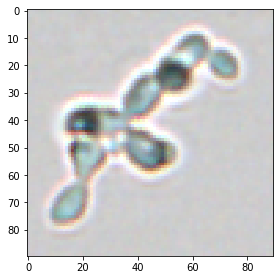

In [65]:
i = -3
# show_images([io.imread(df_preds.iloc[i].fp)])
io.imshow(io.imread(df_preds[df_preds.true_label.isin(['YST'])].iloc[i].fp))

In [51]:
# indices

In [66]:
subset_indices = indices[df_mc_to_find.true_label.isin(['YST'])]
subset_distances = distances[df_mc_to_find.true_label.isin(['YST'])]


In [67]:
# subset_distances[i]

In [68]:
import pickle
df_train = pickle.load(open('../../../data_imgs/knn_annotations_radius_0.7_threshold_0.0_modelb2_v2.pic', 'rb'))
print(df_train[df_train.fp.isin(df_unlabelled.iloc[subset_indices[i]].fp.values)].shape)
df_train[df_train.fp.isin(df_unlabelled.iloc[subset_indices[i]].fp.values)]

(67, 3)


fp pred_class_knn  \
25773   /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            WBC   
76504   /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            YST   
107737  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            WBC   
255349  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            WBC   
289775  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            WBC   
...                                                   ...            ...   
298274  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            YST   
298412  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            YST   
298538  /home/daisuke_ishibe/tmp/vm07f/DB/data/osaka_c...            YST   
334375  /mnt/Users/sucheta_chauhan/14classDataReannota...            YST   
337312  /mnt/Users/sucheta_chauhan/14classDataReannota...            WBC   

        pred_class_prob_knn  
25773              0.545831  
76504              1.000000  
107737             1.000000  
255349             0.509110  
289775             1.000000  
...                     ...  
298274             1.000000  
298412             1.000000  
298538             1.000000  
334375             1.000000  
337312             0.671348  

[67 rows x 3 columns]

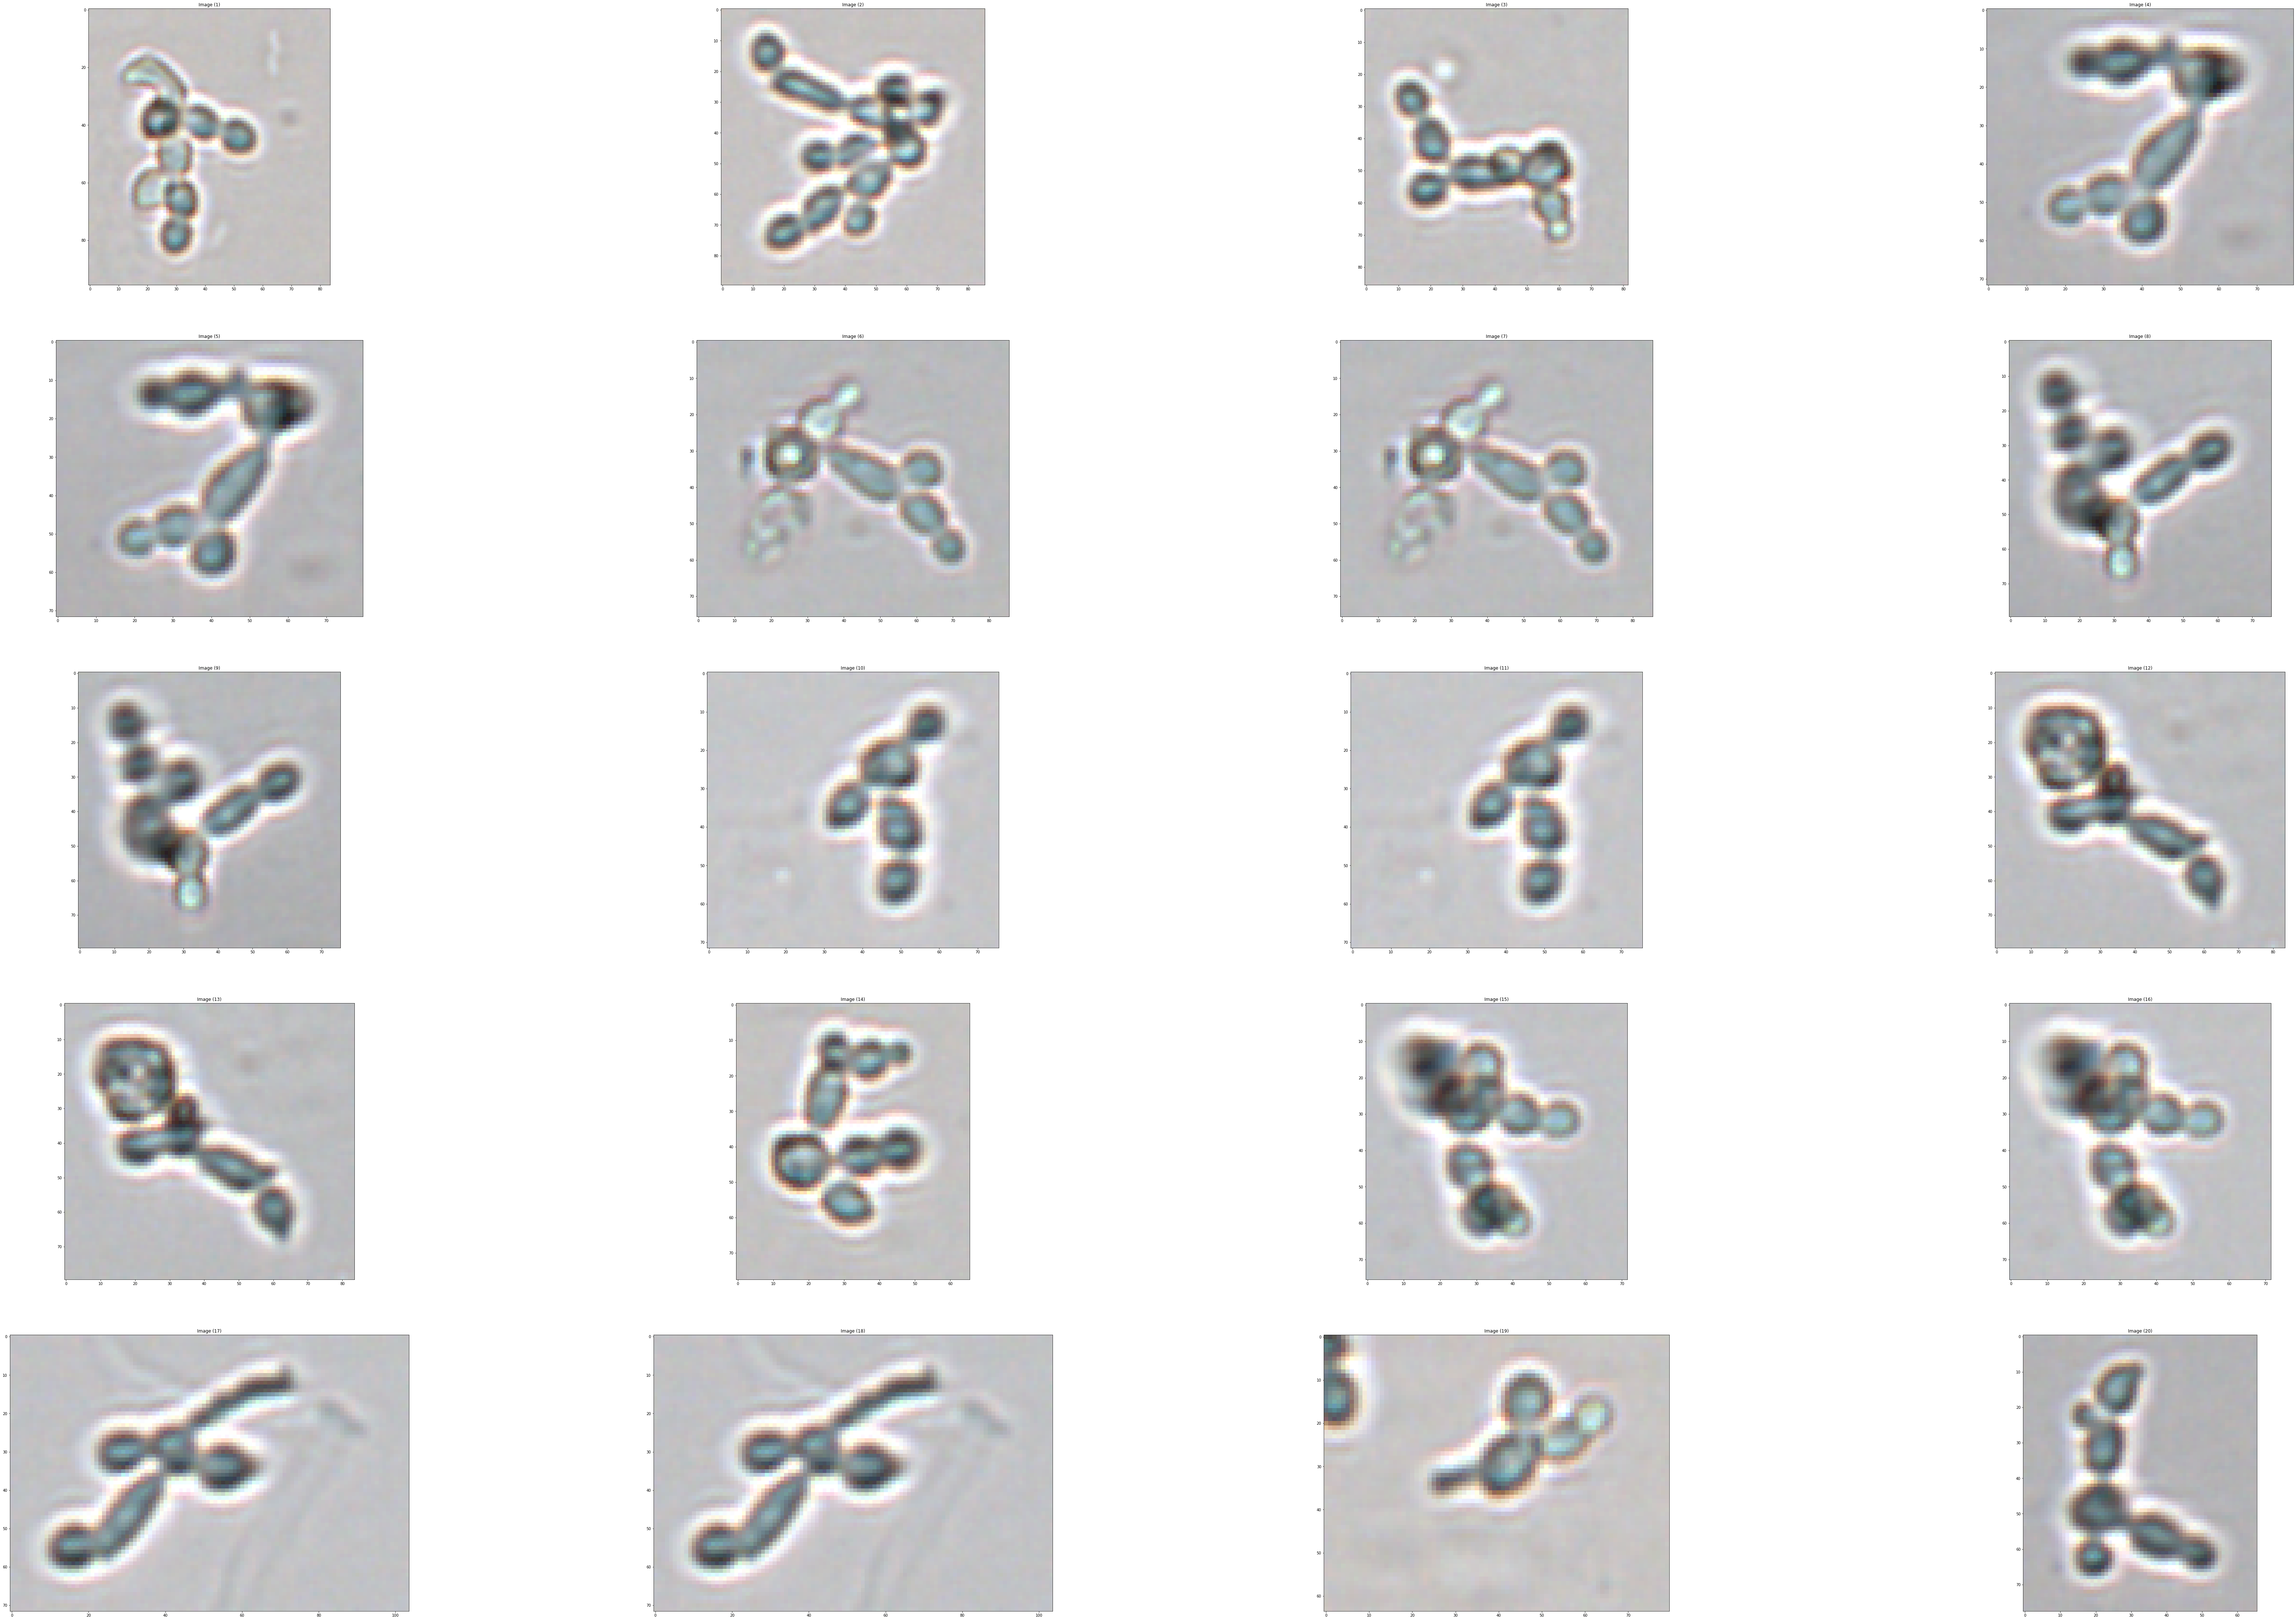

In [71]:
from skimage import io
images = [io.imread(fp) for fp in df_unlabelled.iloc[subset_indices[i]].fp.values[0:20]]
show_images(images)
